<hr size="5" />

### **<font color='DarkCyan'>Salzburg University of Applied Sciences - 2023**  
#### **<font color='DarkCyan'>Information Technology & Systems Engineering**

# **<font color='GoldenRod'>Master Thesis**  
## **<font color='GoldenRod'>Deep Learning for Advancing Animal Breeding: A Study on Austrian Fleckvieh Cattle**

<hr size="5">

#### Student Name: Jakob Ganitzer
#### Degree Program:  ITSM-B

<hr size="5" />

### Imports

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models.megaencoder import MegaChunkRegressor_MLP2
from models.hyenaEncoder import HyenaRegressor_MLP_cat_Reduced
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from models.graphsage import SAGE_OneHot_Linear
from torch_geometric.utils import to_undirected
from torch_geometric.loader import NeighborLoader
import copy

In [2]:
#Mega Config

#paddedLength = 34816
paddedLength = 26624
#paddedLength = 21504

#max_pos = 34900
max_pos = 27000
#max_pos = 21510

#chunk_size = 1024
chunk_size = 512

lr = 0.001 

batch_size = 64 

input_dim = 3
num_layers = 2#4
num_heads = 3

gamma = 0.85

hidden1 = 1000 #1000
hidden2 = 500  #500
hidden3 = 200


In [2]:
#Hyena Config
#Config

#HyenaOperator
order = 2 # 12, 18, 36
activation = 'relu'  #'identity' # 'relu'

#paddedLength = 26283
#max_pos = 35000
max_pos = 27000


lr = 0.001 

batch_size = 128 
num_epochs = 40
val_size = 0.01 

input_dim = 8
num_layers = 2
num_heads = 1

patience = 10

hidden1 = 1000
hidden2 = 500
hidden3 = 200

In [3]:
criterion = nn.MSELoss()

### Load Data

In [4]:
dataRoot = "/data"

In [5]:
heritability = "/h40"
phenotype_path = dataRoot + heritability + heritability + "_simu.dat"
snp_path = dataRoot + heritability + heritability + "_simu.snp"
benchmark_path = dataRoot + heritability + heritability + "_simu.bv"
pedigree_path = dataRoot + heritability + heritability + "_simu.ped"
snpPos_path = dataRoot + heritability + heritability + "_simu_snp.txt"
qtl_path = dataRoot + heritability + heritability + "_simu_qtl.txt"

In [6]:
checkpointRoot = '/data/checkpoints/'

In [6]:
modelName = '_'

In [8]:
heritability = "/h40"

X_path = "/test/snp_X_test_01_maf_one_hot.parquet"

y_path = "/test/snp_y_test_01_maf_one_hot.parquet"

#gen30

X_path = "/test/snpGen30_X_test_01.parquet"

y_path = "/test/snpGen30_y_test_01.parquet"

In [10]:
#Hyena
heritability = "/h40"
X_path = "/test/snp_X_test_01_maf.parquet"

y_path = "/test/snp_y_test_01_maf.parquet"

#gen30
trainPath = '/snp_pheno_BPpos_maf.parquet'
testPath = '/snpTruePheno_gen30_BPpos_maf.parquet'

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [28]:
df_snp_pheno_ped = pd.read_parquet(dataRoot + heritability + '/snp_maf_one_hot.parquet', engine='pyarrow')

In [11]:
X_test_df = pd.read_parquet(dataRoot + heritability + X_path, engine='pyarrow')
y_test_df = pd.read_parquet(dataRoot + heritability + y_path, engine='pyarrow')["phenotype"]

In [7]:
#GraphSage
data = torch.load(dataRoot + heritability + "/graph_maf_float32.pt")

In [10]:
#GraphSage
#Convert directed graph to undirected
data.edge_index = to_undirected(data.edge_index)

In [13]:
X_test_df.drop("id", axis=1, inplace=True)

In [14]:
# Convert the data frame back to a numpy array
X_test = X_test_df.to_numpy()

In [15]:
# Convert the data frame back to a numpy array
X_test = X_test_df.to_numpy()

# Reshape the data back to its original shape
X_test = X_test.reshape(X_test_df.shape[0], int(X_test_df.shape[1]/3), 3)


In [16]:
 # Create attention_mask (torch.FloatTensor of shape (batch_size, sequence_length)) for train and val
attention_mask_test = torch.ones(X_test.shape[0], X_test.shape[1]).to('cpu')

if(paddedLength != -1 and paddedLength > X_test.shape[1]):
    pad = paddedLength - X_test.shape[1]
    # Pad the data to the max length
    X_test = np.pad(X_test, ((0,0),(0,pad),(0,0)), 'constant', constant_values=0)
    attention_mask_test = F.pad(attention_mask_test, (0,pad), 'constant', 0)

In [17]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to('cpu')

y_test_tensor = torch.tensor(y_test_df.values, dtype=torch.float32).to('cpu')

In [18]:
num_features = X_test_tensor.shape[1]

In [15]:
def add_value(x, value):
    return x + value
#gen30
#cat
df_snp_pheno_train = pd.read_parquet(dataRoot + heritability + trainPath, engine='pyarrow')
df_snp_pheno_test = pd.read_parquet(dataRoot + heritability + testPath, engine='pyarrow')

X_val_df = df_snp_pheno_test.drop(columns=['phenotype', 'id'], axis=1)
y_val = df_snp_pheno_test["phenotype"]

# apply the function to each element of the DataFrame
X_val_df = X_val_df.apply(add_value, value=7)

X_test_tensor = torch.tensor(X_val_df.to_numpy(), dtype=torch.int).to('cpu')

y_test_tensor = torch.tensor(y_val.values, dtype=torch.float).to('cpu')

num_features = X_test_tensor.shape[1]

#onehot

In [22]:
#model = MegaChunkRegressor_MLP(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, max_pos=max_pos, hidden1 = hidden1, hidden2 = hidden2, hidden3 = hidden3, num_features = num_features, chunk_size=chunk_size).to(device)
model = MegaChunkRegressor_MLP2(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, max_pos=max_pos, hidden1 = hidden1, hidden2 = hidden2, hidden3 = hidden3, num_features = num_features, chunk_size=chunk_size).to(device)

In [ ]:
#Hyena
model = HyenaRegressor_MLP_cat_Reduced(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, max_pos=num_features, hidden1 = hidden1, hidden2 = hidden2, hidden3 = hidden3, num_features = num_features, order = order, activation = activation).to(device)
#model = HyenaRegressor_MLP_cat(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, max_pos=num_features, hidden1 = hidden1, hidden2 = hidden2, hidden3 = hidden3, num_features = num_features, order = order, activation = activation).to(device)

In [ ]:
hidden1= 128
hidden2= 64
embed_dim = 256
#model = SAGE_OneHot_MLP(data.x.size(1)* data.x.size(2), embed_dim, 1,hidden1 = hidden1, hidden2 = hidden2).to(device)
#model = SAGE_OneHot_MLP(data.x.size(1), embed_dim, 1,hidden1 = hidden1, hidden2 = hidden2).to(device)

model = SAGE_OneHot_Linear(data.x.size(1)* data.x.size(2), embed_dim, 1,hidden1 = hidden1, hidden2 = hidden2).to(device)

In [ ]:
# Load the saved checkpoint
checkpoint = torch.load(checkpointRoot + modelName + '/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
model.eval()

In [26]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory = True,num_workers = 2)

In [38]:
inference_df = pd.DataFrame(columns=['targets', 'output'])
dtype1 = torch.cuda.IntTensor
dtype2 = torch.cuda.FloatTensor

with torch.no_grad():
    for data, targets in test_loader:
        with torch.cuda.amp.autocast():
            data = data.to(device).type(dtype1)
            targets = targets.to(device).type(dtype2)

            output,pooled_output, embedding = model(data)
            
            targets_np = targets.cpu().numpy()
            output_np = output.cpu().numpy()

            temp_df = pd.DataFrame({
                'targets': targets_np,
                'output': output_np
            })

            inference_df = pd.concat([inference_df, temp_df], ignore_index=True)

In [26]:
inference_df = pd.DataFrame(columns=['targets', 'output'])
dtype = torch.cuda.FloatTensor

with torch.no_grad():
    for data, targets, attention_mask_val in test_loader:
        with torch.cuda.amp.autocast():
            data = data.to(device).type(dtype)
            targets = targets.to(device).type(dtype)
            attention_mask_val = attention_mask_val.to(device).type(torch.cuda.IntTensor)

            output,_,_ = model(data, attention_mask_val)
            
            targets_np = targets.cpu().numpy()
            output_np = output.cpu().numpy()

            temp_df = pd.DataFrame({
                'targets': targets_np,
                'output': output_np
            })

            inference_df = pd.concat([inference_df, temp_df], ignore_index=True)

In [18]:
#GraphSage
batch_size = 64
kwargs = {'batch_size': batch_size, 'num_workers': 0, 'persistent_workers': False}
subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)

model.eval()  
total_loss = 0.
total_mae = 0.  
total_r2 = 0. 
total_pearson = 0. 
total_pvalue = 0.

dtype = torch.cuda.FloatTensor

y_hat, embeddings = model.inference(data.x, subgraph_loader, device)
target = data.y.to(y_hat.device)

total_loss = []
total_mae = []
total_r2 = []
total_pearson = []
total_pvalue = []

mask = data.test_mask

loss = criterion(y_hat[mask], target[mask])
mae = mean_absolute_error(target[mask].cpu().numpy(), y_hat[mask].detach().cpu().numpy())
r2 = r2_score(target[mask].cpu().numpy(), y_hat[mask].detach().cpu().numpy())
_pearsonr, _pvalue = pearsonr(target[mask].cpu().numpy(), y_hat[mask].detach().cpu().numpy())


In [ ]:
last_embeddings = embeddings[-1]
embeddings_np = last_embeddings.cpu().numpy().astype('float32')

In [21]:
#inference_df = pd.DataFrame(columns=['targets', 'output'])
inference_df = pd.DataFrame(columns=['targets', 'output', 'id'])

In [22]:
# Create a list of dictionaries to populate the DataFrame
dataSage = []
for t, y in zip(target, y_hat):
    dataSage.append({'targets': t.item(), 'output': y.item()})

# Populate the DataFrame using concat
inference_df = pd.concat([inference_df, pd.DataFrame(dataSage)], ignore_index=True)
inference_df['id'] = data.node_ids

In [24]:
data_dict = {}
for i in range(embeddings_np.shape[1]):
    column_name = f"embedding_{i}"
    data_dict[column_name] = embeddings_np[:, i]

df_pooled_output = pd.DataFrame(data_dict)

In [25]:
combined_df = pd.concat([inference_df, df_pooled_output], axis=1)

In [29]:
targets = torch.tensor(inference_df['targets'].values).to(device)
output = torch.tensor(inference_df['output'].values).to(device)

In [26]:
combined_df.to_parquet(dataRoot + heritability + '/df_graphSage_hyenaEmbeddings.parquet')

In [44]:
loss = criterion(output, targets)
mae = mean_absolute_error(targets.cpu().numpy(), output.detach().cpu().numpy())
r2 = r2_score(targets.cpu().numpy(), output.detach().cpu().numpy())
_pearsonr, _pvalue = pearsonr(targets.cpu().numpy(), output.detach().cpu().numpy())

In [ ]:
print("Loss:", loss)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)
print("Pearson Correlation Coefficient:", _pearsonr)
print("p-value:", _pvalue)

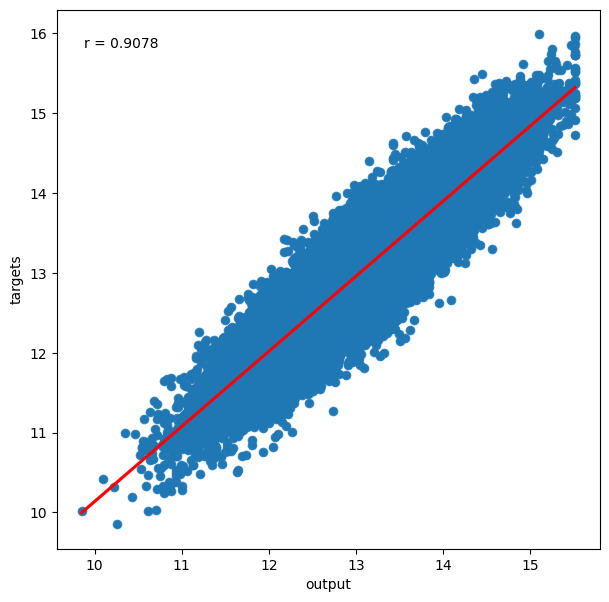

In [34]:
# Show correlation between phenotypes

fig, ax = plt.subplots(figsize=(7, 7))  # Create a single plot (one set of axes)

# Scatter plot
sns.scatterplot(data=inference_df, x="output", y="targets", ax=ax)

# Add trendline
sns.regplot(data=inference_df, x="output", y="targets", ax=ax, line_kws={"color": "red"})

# Add correlation coefficient
r = inference_df["output"].corr(inference_df["targets"])
ax.text(0.05, 0.95, "r = {:.4f}".format(r), transform=ax.transAxes, va="top")

plt.show()  # Display the plot
